# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.87KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

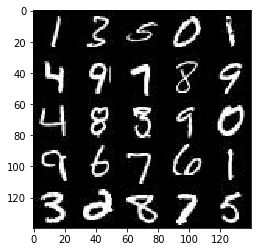

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

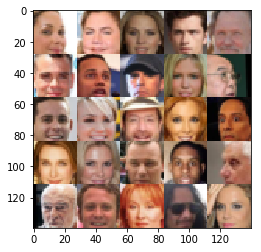

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.contrib.layers.layer_norm(x2)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.contrib.layers.layer_norm(x3)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.contrib.layers.layer_norm(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.contrib.layers.layer_norm(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.contrib.layers.layer_norm(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0289... Generator Loss: 4.1567
Epoch 1/2... Discriminator Loss: 2.3623... Generator Loss: 0.0993
Epoch 1/2... Discriminator Loss: 0.1681... Generator Loss: 1.8735
Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 6.7080
Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 8.9295
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.6637
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.4993
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.0380
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 12.6452
Epoch 1/2... Discriminator Loss: 16.6348... Generator Loss: 0.0000


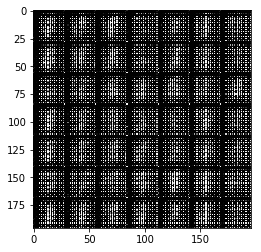

Epoch 1/2... Discriminator Loss: 2.4237... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 2.0700
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 3.4307... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 0.2590... Generator Loss: 2.2094
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.7638... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 0.3656
Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.8051


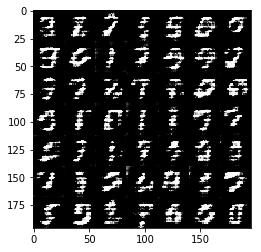

Epoch 1/2... Discriminator Loss: 1.6306... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.7463... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 1.6174... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.5966... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.5291... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.7133... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.6754


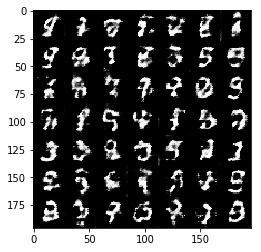

Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.6141


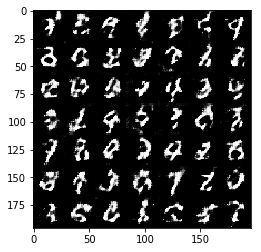

Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.7326


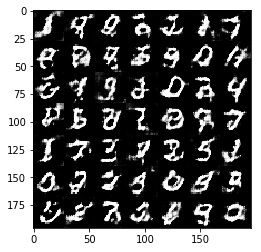

Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.7580


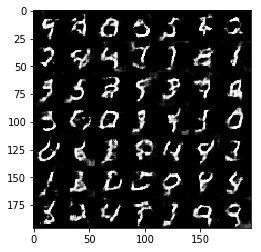

Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.6263


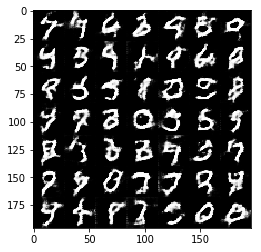

Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.6164
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.7215


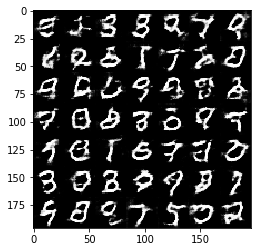

Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.5839
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 0.4292


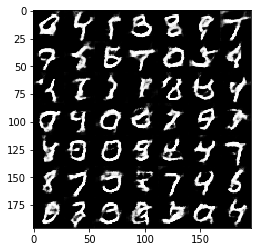

Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.5713
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.5617
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.5439
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.6491


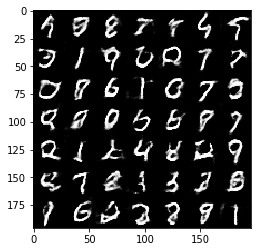

Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.5327
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.4731... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.5790


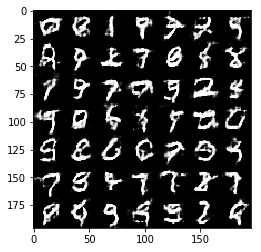

Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.4429... Generator Loss: 0.5198
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.4978... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.4761... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.6572


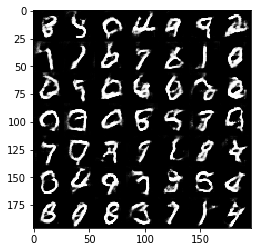

Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.4942
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.4333... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.5641


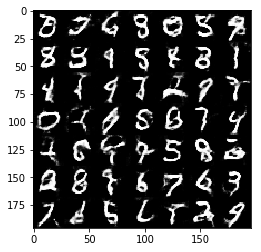

Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.4951... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.5562


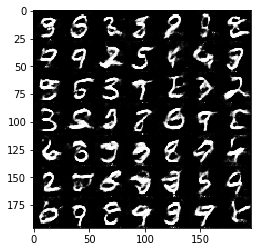

Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.4910... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.6059


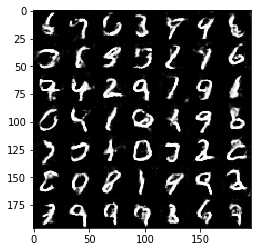

Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.4356... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 1.4613... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5429
Epoch 2/2... Discriminator Loss: 1.4493... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.5781


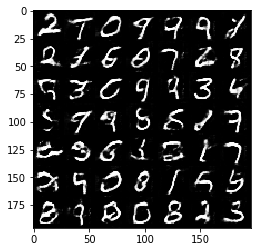

Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.5773... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.5071
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.5924


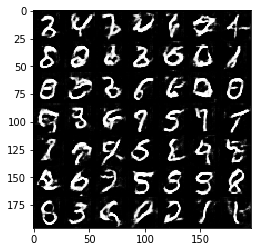

Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.4948... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.6244
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.6063
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.6961


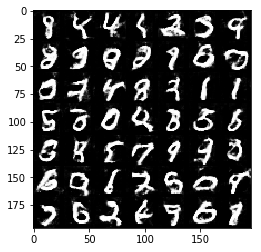

Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.8460


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1272... Generator Loss: 0.2037
Epoch 1/1... Discriminator Loss: 3.1673... Generator Loss: 0.1015
Epoch 1/1... Discriminator Loss: 2.8318... Generator Loss: 0.0973
Epoch 1/1... Discriminator Loss: 3.1217... Generator Loss: 0.0793
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 2.0107... Generator Loss: 2.6029
Epoch 1/1... Discriminator Loss: 2.5612... Generator Loss: 0.1337
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.5138


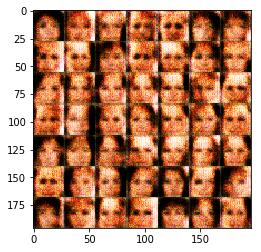

Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.6498
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.8077... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7178


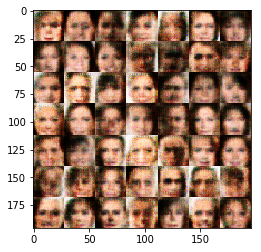

Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6194


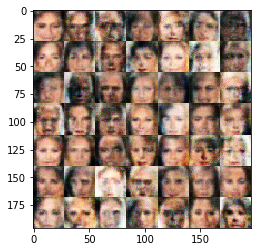

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6039


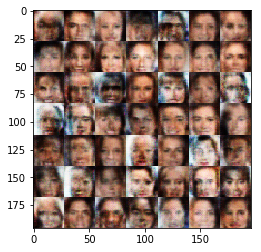

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5928


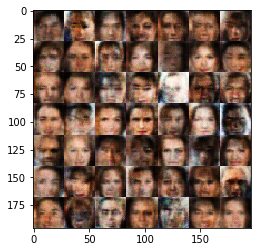

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.5878


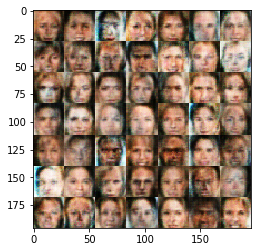

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6314


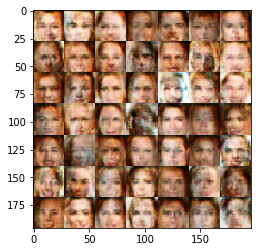

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6197


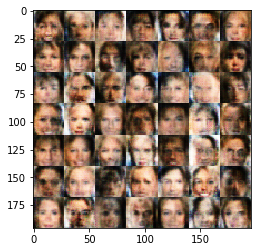

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6210


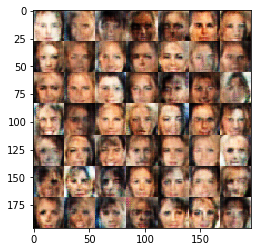

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6132


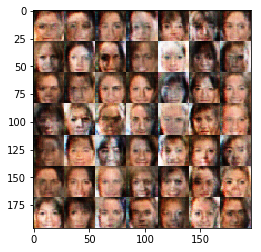

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6341


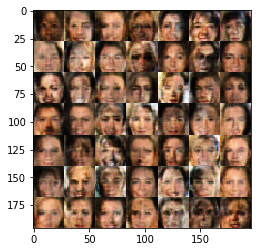

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6219


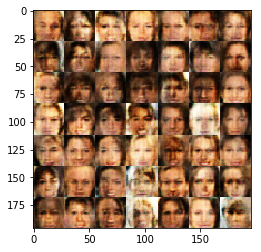

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6419


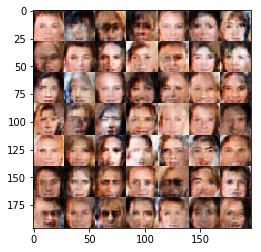

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6367


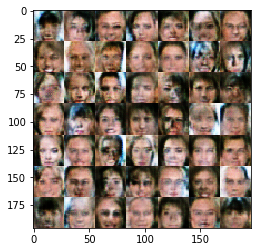

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6460


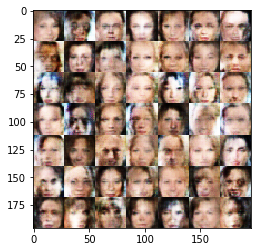

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6461


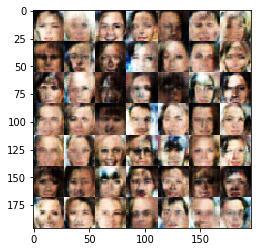

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6400


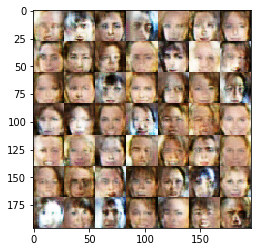

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6542


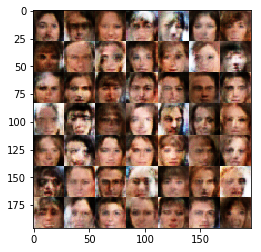

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6506


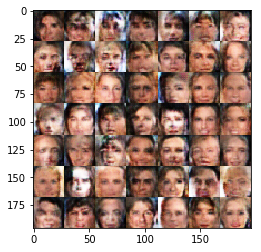

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6609


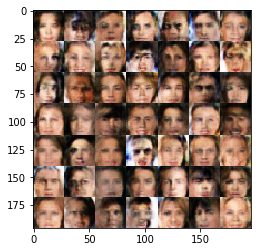

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6582


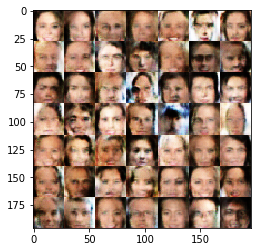

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6560


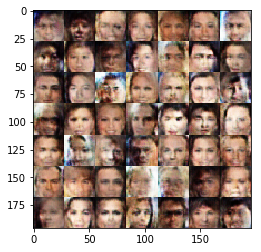

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6515


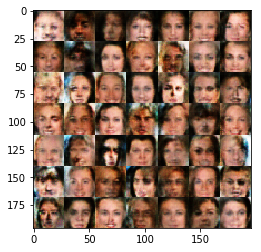

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6624


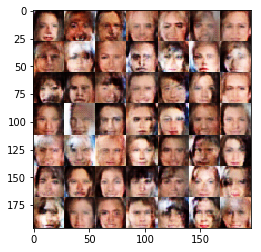

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6583


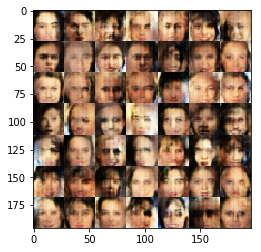

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6595


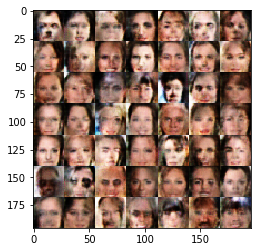

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6614


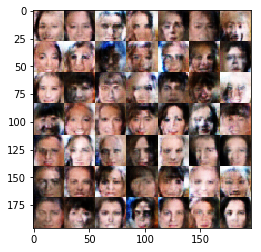

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6653


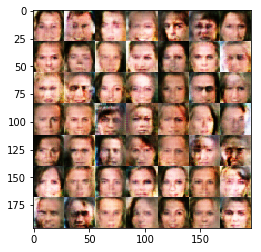

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6614


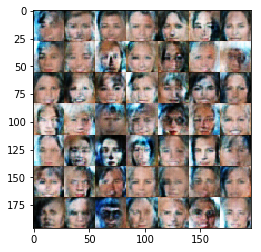

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6655


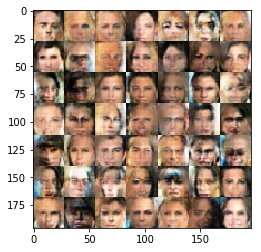

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6655


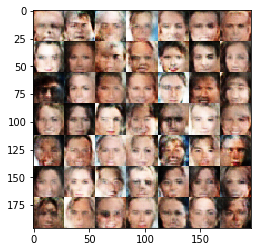

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6636


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.